# Investment Rate of Return Calculation

Original author: David Banas <capn.freako@gmail.com>  
Original date:   April 8, 2019

Copyright &copy; 2019 David Banas; all rights reserved World wide.

<a name="contents"/>


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Importing-the-Data" data-toc-modified-id="Importing-the-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Importing the Data</a></span></li><li><span><a href="#The-Multiple-Holding-Periods-Approach" data-toc-modified-id="The-Multiple-Holding-Periods-Approach-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>The <em>Multiple Holding Periods</em> Approach</a></span></li><li><span><a href="#Correcting-for-Cash-Injections" data-toc-modified-id="Correcting-for-Cash-Injections-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Correcting for Cash Injections</a></span><ul class="toc-item"><li><span><a href="#Explaining-the-Idea" data-toc-modified-id="Explaining-the-Idea-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Explaining the Idea</a></span></li><li><span><a href="#Correcting-the-Data" data-toc-modified-id="Correcting-the-Data-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Correcting the Data</a></span></li><li><span><a href="#Checking-the-Results" data-toc-modified-id="Checking-the-Results-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Checking the Results</a></span></li></ul></li><li><span><a href="#Checking-Curve-Fit-Quality" data-toc-modified-id="Checking-Curve-Fit-Quality-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Checking Curve Fit Quality</a></span><ul class="toc-item"><li><span><a href="#Qualitative-Assessment-of-2-pt.-Fits" data-toc-modified-id="Qualitative-Assessment-of-2-pt.-Fits-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Qualitative Assessment of 2-pt. Fits</a></span></li><li><span><a href="#Quantitative-Measurement-of-2-pt.-Fits" data-toc-modified-id="Quantitative-Measurement-of-2-pt.-Fits-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Quantitative Measurement of 2-pt. Fits</a></span></li><li><span><a href="#Finding-the-Best-Fit-to-All-the-Data" data-toc-modified-id="Finding-the-Best-Fit-to-All-the-Data-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Finding the Best Fit to All the Data</a></span></li><li><span><a href="#Stability-in-Predicted-Yield-of-Best-Fit-Curve" data-toc-modified-id="Stability-in-Predicted-Yield-of-Best-Fit-Curve-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Stability in Predicted Yield of <em>Best Fit</em> Curve</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusion</a></span></li><li><span><a href="#Analyzing-Your-Own-Data" data-toc-modified-id="Analyzing-Your-Own-Data-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Analyzing Your Own Data</a></span></li></ul></div>

## Introduction

This [Jupyter](http://jupyter.org) notebook offers some insights into calculating the _average annualized rate of return_ on an investment fund into which several point cash infusions have been made (i.e. - a typical 401(k) or IRA, for instance).

The popular _Motley Fool_ site offers [this recipe](https://www.fool.com/about/how-to-calculate-investment-returns/) for calculating the average annualized rate of return on investments with _cash flow events_, but it suffers from a rather serious flaw: it uses just 2 points (beginning and end) to calculate the rate of return for any particular _holding period_.
This makes the calculation very susceptible to the ordinary random fluctuations in the values of the various securities held in the fund.

A better way is to fit an exponential curve to the entire data set using the [_least squares_](https://en.wikipedia.org/wiki/Least_squares) method.
This approach has the advantage that _every_ point in the data set contributes to the estimate of return rate.
(Note that the _Motley Fool_ approach is also doing exponential curve fitting, but uses only two data points - first and last.)

However, we can't do this using the raw data, because we'd unfairly credit the fund performance for the cash injections we make.
That is, the fund didn't _earn_ the increase in its balance that occurred when we deposited some cash into it.

So, before attempting a _single holding period_ analysis of the fund performance, we have to correct for these cash injections somehow.
I propose a method for doing this that flows from the simple notion:

> The fund "gain" immediately before a cash injection should be the same as immediately after.

I apply this method and then check its results against the simpler one prescribed by _The Fool_.

The data used here are the actual results of my own investment in the [_Charles Schwab SWDRX_](https://client.schwab.com/secure/cc/research/mutual_funds/mfs.html?path=/research/Client/MutualFunds/Summary&symbol=SWDRX) fund, a targeted mutual fund intended for use by those planning to retire in (or, very near) 2030.
The data have been normalized, to disguise the actual value I have invested.

<a href="#contents">Back to Contents</a>


## Importing the Data

The data used here are stored in a _comma separated value_ (CSV) file, a very common format used when exporting spreadsheet data.
The data matrix contains the following columns:

- _Date_ - The date for each row.
    
- _Balance_ - The actual (normalized) dollar value of the account.
Note that this amount reflects all reinvested dividends and capital gains, as well as the fund share price changes.
(In my case, all dividends and capital gains have been reinvested.)

- _Xfr In_ - External injections of cash into the account.
    
**Note:** For rows containing a non-zero value in the _Xfr In_ column the amount in the _Balance_ column is assumed to include the cash injected.
That is, all balances are given _post_-cash injection.


In [1]:
%matplotlib inline 
from matplotlib import pyplot as plt

import numpy  as np
import pandas as pd

filename = "DavesIRA.csv"
df = pd.read_csv(filename, parse_dates=['Date'],
                 dtype={'Balance': np.float64,
                        'XfrIn'  : np.float64
                        })


<a href="#contents">Back to Contents</a>


## The _Multiple Holding Periods_ Approach

The approach suggested by _The Motley Fool_ segregates the data on boundaries of non-zero values in the _Xfr In_ column and calculates the return for each of these _holding periods_ independently.
(That's how they avoid the messy subject of correcting for cash injections.)

In [2]:
def findXfrIns(df):
    """Find all rows containing cash injections."""
    ixs = list(np.where(df.XfrIn != 0)[0])
    if(ixs[0] == 0):  # We know the opening balance occurred
      ixs = ixs[1:]   # due to a cash injection.
    return ixs
    
def findMHPs(df):
    """Find start/end balances of all multiple holding periods."""
    ixs = findXfrIns(df)
    ixPrs = zip([0] + ixs, ixs)
    valPrs = map(lambda ixPr: (df.iloc[ixPr[0]]['Balance'],
                               df.iloc[ixPr[1]]['Balance'] - df.iloc[ixPr[1]]['XfrIn']),
                 ixPrs)
    valPrs += [(df.iloc[ixs[-1]]    ['Balance'],
                df.loc[df.index[-1]]['Balance'])]
    return valPrs

def calcMHPReturns(df):
    """Calculate returns for all multiple holding periods."""
    valPrs = findMHPs(df)
    returns = []
    for valPr in valPrs:
        returns.append(valPr[1] / valPr[0])
    return (returns, valPrs)
    
def printMHPReturns(df):
    """Print the returns, using the Motley Fool approach."""
    print "Holding Period Analysis:"
    print ""
    print "Period   Beginning Balance   Ending Balance   Return"
    print "____________________________________________________"
    (returns, valPrs) = calcMHPReturns(df)
    period = 0
    for ret in returns:
        startVal = valPrs[period][0]
        endVal   = valPrs[period][1]
        partRet  = ret
        period  += 1
        print "%4d           %6.4f              %6.4f     %6.4f" % \
              (period, startVal, endVal, partRet)
    print "____________________________________________________"

    totRet    = np.prod(returns)
    startDate = df.iloc[0]['Date']
    endDate   = df.iloc[-1]['Date']
    daysHeld  = (endDate - startDate).days
    dailyRet  = totRet ** (1. / daysHeld)
    aveAnnRet = dailyRet ** 365

    print "Total Return:                                 %6.4f" % (totRet)
    print ""
    print "Start Date:", startDate
    print "End Date:  ", endDate
    print "Days Held: ", daysHeld
    print "Average annualized yield: %4.1f%%" % ((aveAnnRet - 1)*100)
    
printMHPReturns(df)

Holding Period Analysis:

Period   Beginning Balance   Ending Balance   Return
____________________________________________________
   1           1.0000              1.2571     1.2571
   2           1.9776              2.7415     1.3863
   3           4.1417              5.2220     1.2608
   4           5.4079              5.4486     1.0075
____________________________________________________
Total Return:                                 2.2138

Start Date: 2006-04-10 00:00:00
End Date:   2019-02-28 00:00:00
Days Held:  4707
Average annualized yield:  6.4%


Note, in the table above, the discrete jumps between the _Ending Balance_ value in one row and the _Beginning Balance_ value in the next.
You're seeing the effect of a _point cash injection_ into the fund.

So, the approach recommended by _The Motley Fool_ tells me I've been getting an average annual yield of: **6.4%**.

Here's what Schwab says about this fund:

![](schwab.png)

I notice the following:

1. Their "since inception" number, which includes about an extra 9 months compared to my own time frame, is pretty close to my calculated value.
1. The average return numbers vary wildly with analysis time frame.
Why is this?
Let's take a look at the raw data:


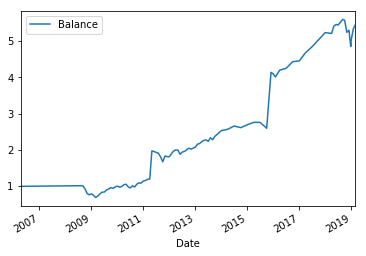

In [3]:
df.plot(x='Date', y='Balance')
plt.show()

Some notes on the plot above:

1. The long flat stretch at the left is due to missing data.
Schwab only provides data going back 10 years, and I didn't start this tracking project until last year.
    
1. The last cash injection is difficult to see, due to its small size.
It occured on April 30, 2018.

So, what happens if I redo the calculation, omitting that initial flat stretch?

In [4]:
printMHPReturns(df[1:])

Holding Period Analysis:

Period   Beginning Balance   Ending Balance   Return
____________________________________________________
   1           1.0175              1.2571     1.2355
   2           1.9776              2.7415     1.3863
   3           4.1417              5.2220     1.2608
   4           5.4079              5.4486     1.0075
____________________________________________________
Total Return:                                 2.1757

Start Date: 2008-08-31 00:00:00
End Date:   2019-02-28 00:00:00
Days Held:  3833
Average annualized yield:  7.7%


And if I look at the last 10 years:

In [5]:
printMHPReturns(df.loc[df.Date >= '2009-03-31'])

Holding Period Analysis:

Period   Beginning Balance   Ending Balance   Return
____________________________________________________
   1           0.7328              1.2571     1.7155
   2           1.9776              2.7415     1.3863
   3           4.1417              5.2220     1.2608
   4           5.4079              5.4486     1.0075
____________________________________________________
Total Return:                                 3.0210

Start Date: 2009-03-31 00:00:00
End Date:   2019-02-28 00:00:00
Days Held:  3621
Average annualized yield: 11.8%


And the result agrees very well with the Schwab claim: 11.33%.

So it seems the _Motley Fool_ approach is able to get us close to the Schwab numbers, but those numbers are varying quite wildly, depending upon our chosen time interval.
That wild variation isn't very confidence inspiring, regarding our ability to predict the future performance of this fund. :(

Let's see if we can get more stable results by fitting an exponential curve to _all_ the data points.
Before we can do that, we need to correct for the 3 _point cash injections_.
Otherwise, they'll unfairly increase our estimate of the fund performance.

<a href="#contents">Back to Contents</a>


## Correcting for Cash Injections

### Explaining the Idea

The idea behind cash injection correction is simple:

> The gain calculated immediately before the cash injection should equal the gain calculated immediately after.
That way, the injection of cash does _not_ influence our estimate of the fund performance.

In order to calculate a _gain_ from a _balance_, we add a _basis_ to the data.
Up until the first cash injection, the basis is simply the opening balance of the account.
We apply our guiding principle, above, to determine what the basis should be immediately after the first cash injection.
And it remains that value until the next cash injection, at which time we repeat the calculation.

**Note:** Any cash injection mentioned in the _Xfr In_ column of the first row of data is ignored.

**Example:** Assume row N contains our first cash injection.
Because the balance, $B_N$, given in any row containing a non-zero cash injection, $C_N$, is assumed to include that injection, we have for the balance immediately before the injection:

$$
B' = B_N - C_N
$$

where $C_N$ is the value in the _Xfr In_ column of row N.

And for the _gain_ immediately before the injection:

$$
G' = \frac{B'}{P_{N-1}}
$$

where $P_{N-1}$ is the _basis_ value for row $N-1$.

Now, to calculate the new basis value, $P_N$, we simply refer to our guiding principle, above, and require:

$$
G = \frac{B_N}{P_N} = G' = \frac{B'}{P_{N-1}}
$$

from which we derive:

$$
P_N = \frac{B_N}{B'} \, P_{N-1} = \frac{B_N}{B_N - C_N} \, P_{N-1}
$$

Note that the above formula can be used to populate the new _Basis_ column for all rows except the first (for which _Basis_ = _Balance_), since when $C_N = 0$ we have: $P_N = P_{N-1}$, which is correct.

<a href="#contents">Back to Contents</a>

### Correcting the Data

Using the above, let's create and populate two new columns in our data frame: _Basis_ and _Gain_...

In [6]:
basis = [df.iloc[0]['Balance']]  # Prime the basis w/ the initial balance.
gain  = [1.0]
for ix in range(1, len(df.index)):
    tmpRow   = df.iloc[ix]
    tmpBal   = tmpRow['Balance']
    tmpBasis = basis[-1] * tmpBal / (tmpBal - tmpRow['XfrIn'])  # (4) above
    basis.append(tmpBasis)
    gain.append(tmpBal / tmpBasis)
df['Basis'] = basis
df['Gain']  = gain
# print df.dtypes
# print df


<a href="#contents">Back to Contents</a>


### Checking the Results

Now, let's check our new, corrected, single holding period data against our previous results...

In [7]:
def getSHPReturn(df, ix):
    """Get the return, using the corrected data."""
    daysHeld  = (df.iloc[-1]['Date'] - df.iloc[ix]['Date']).days
    totRet    = df.iloc[-1]['Gain'] / df.iloc[ix]['Gain']
    dailyRet  = totRet ** (1. / daysHeld)
    return(dailyRet ** 365)  # Average annualized yield.

rets = [getSHPReturn(df, ix)
        for ix in [0, 1, np.where(df['Date'] >= '2009-03-31')[0][0]]]
for ret in rets:
    print "%4.1f%%" % ((ret - 1) * 100)
    

 6.4%
 7.7%
11.8%


And these results agree precisely with our previous work.
So, we can trust the new, corrected, single holding period data in the _Gain_ column of our dataframe to give us the same results as the multiple holding period approach prescribed by _The Motley Fool_.
Good! Now, let's see how well our 3 curves fit this new data...

<a href="#contents">Back to Contents</a>

## Checking Curve Fit Quality

### Qualitative Assessment of 2-pt. Fits

Now, let's plot our 3 _2-point exponential fits_ from above (i.e. - "first / last", "second / last", and "10-yrs. back / last") against our new _Gain_ data. (The _Gain_ data is what we're trying to model accurately, because it's what we'd like to be able to predict.)

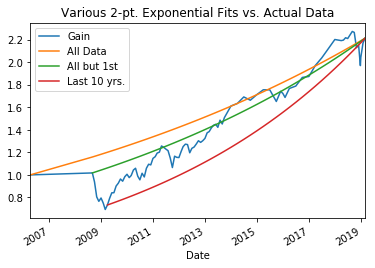

In [8]:
startDate = df.iloc[0]['Date']
finalDate = df.iloc[-1]['Date']
ref       = df['Gain'].values
finalVal  = ref[-1]
startIxs  = [0, 1, np.where(df['Date'] >= '2009-03-31')[0][0]]
labels    = ['All Data',
             'All but 1st',
             'Last 10 yrs.']
# Note: zip(*x) is how we do unzip(x) in Python.
(initVals, initDates, bVals) = map(list, zip(*[
    (ref[ix], df.iloc[ix]['Date'], df.iloc[ix]['Gain'])
    for ix in startIxs]))
mVals = [np.exp(np.log(finalVal / initVal) / (finalDate - initDate).days)
         for (initVal, initDate) in zip(initVals, initDates)]

def plotFits(labels, starts, bVals, mVals):
    """Plot various exponential curves against Gain."""
    df.plot(x='Date', y='Gain')
    for (label, ix, b, m) in zip(labels, starts, bVals, mVals):
        xs = (df['Date'] - df.iloc[ix]['Date']).map(
            lambda x: getattr(x, 'days'))
        ys = [b * m**x for x in xs]
        plt.plot(df.iloc[ix:]['Date'], ys[ix:], label=label)
    plt.legend()
    plt.title("Various 2-pt. Exponential Fits vs. Actual Data")
    plt.show()

plotFits(labels, startIxs, bVals, mVals)


The plot above gives us a strong visual intuition about what's going on:
The growth rate of a simple 2-point exponential fit curve is _strongly_ affected by our chosen starting point.
Judging visually and qualitatively, we'd say that the "All but 1st" curve is the best fit to the actual data, but how might we assess the fit _quantitatively_?

<a href="#contents">Back to Contents</a>

### Quantitative Measurement of 2-pt. Fits

The [_Coefficient of Determination_](https://en.wikipedia.org/wiki/Coefficient_of_determination) (a.k.a. - "$R^2$") method is the most generally accepted approach to determining the "goodness of fit" of a model to actual data.
Let's measure this coefficient for our 3 models...

In [9]:
def r2(y, y_fit):
    """Calculate the 'Coefficient of Determination' (R^2-value)."""
    ss_res = np.sum((y - y_fit) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    return(1 - (ss_res / ss_tot))
    
def printR2Vals(labels, starts, bVals, mVals):
    print "R^2 Values of Fits:"
    print ""
    print "Case                     R^2-value"
    print "__________________________________"
    for (label, ix, b, m) in zip(labels, starts, bVals, mVals):
        xs = (df.iloc[ix:]['Date'] - df.iloc[ix]['Date']).map(lambda x: getattr(x, 'days'))
        ys = df.iloc[ix:]['Gain'].values
        y_fit = [b * m**x for x in xs]
        print "     %-20s  %6.4f" % (label, r2(ys, y_fit))

printR2Vals(labels, startIxs, bVals, mVals)


R^2 Values of Fits:

Case                     R^2-value
__________________________________
     All Data              0.7593
     All but 1st           0.9118
     Last 10 yrs.          0.7483


And our initial visual intuition is confirmed: the "All but 1st" curve is the best fit to the actual _Gain_ data.

<a href="#contents">Back to Contents</a>

### Finding the Best Fit to All the Data

Now, how might we find the _best_ exponential fit to _all_ the data?

We have for our assumed model of a financial investment:

$$
y = b \cdot m^x
$$

where $y$ is the value of our investment at some date, $x$, and $b$ and $m$ are our (to be optimized) _model parameters_.

Taking the logarithm of both sides:

$$
\log y = \log (b \cdot m^x) = \log b + \log m^x = \log b + x \cdot \log m
$$

or:

$$
y' = m' \, x + b'
$$

where:

- $y' = \log y$
- $b' = \log b$
- $m' = \log m$

Well, (7) is just the equation for a line.
And there are lots of library routines available for doing [_linear regression_](https://en.wikipedia.org/wiki/Linear_regression) (i.e. - fitting a line to a data set).
One such routine (available to us, since we're using [_Python_](https://www.python.org)), which is widely used and trusted, is provided by the [_SciPy_](https://www.scipy.org) [_Statistics_ module](https://docs.scipy.org/doc/scipy/reference/tutorial/stats.html): [_linregress_](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html?highlight=linregress#scipy.stats.linregress).
Let's use it to find the best fit exponential curve to our _Gain_ data, and add it to our plot and _R^2 Values_ table...


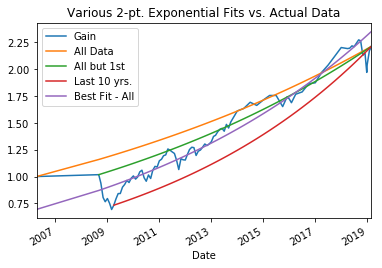

R^2 Values of Fits:

Case                     R^2-value
__________________________________
     All Data              0.7593
     All but 1st           0.9118
     Last 10 yrs.          0.7483
     Best Fit - All        0.9507


In [10]:
from scipy.stats import linregress

def expFit(df):
    xs = (df['Date'] - df.iloc[0]['Date']).map(lambda x: getattr(x, 'days'))
    ys = np.log(df['Gain'].values)  # y', above.
    slope, intercept, r_value, p_value, std_err = linregress(xs, ys)
    # print "R^2-value of linear regression: %6.4f" % (r_value ** 2)
    b = np.exp(intercept)  # 'intercept' is b', above.
    m = np.exp(slope)      # 'slope' is m', above.
    return (b, m)

(b, m) = expFit(df)
labels.append('Best Fit - All')
startIxs.append(0)
bVals.append(b)
mVals.append(m)
plotFits(labels, startIxs, bVals, mVals)
printR2Vals(labels, startIxs, bVals, mVals)


And we see that the _Best Fit_ curve has the highest $R^2$ value, indicating that it is the best model for the data.

<a href="#contents">Back to Contents</a>

### Stability in Predicted Yield of _Best Fit_ Curve

What average annualized rate of return does our new _Best Fit_ curve predict?

In [11]:
print "The average annualized yield predicted by the best fit exponential curve for the data is: %5.2f%%." % ((mVals[-1]**365 - 1)*100)

The average annualized yield predicted by the best fit exponential curve for the data is:  9.93%.


How stable is this prediction?

To answer this question, let's repeat the fitting using the same 3 trimmed versions of the data we've been using...

Case             Yield
______________________
All Data          9.9%
All but 1st      10.2%
Last 10 yrs.      9.9%


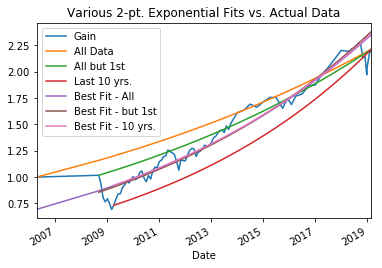

R^2 Values of Fits:

Case                     R^2-value
__________________________________
     All Data              0.7593
     All but 1st           0.9118
     Last 10 yrs.          0.7483
     Best Fit - All        0.9507
     Best Fit - but 1st    0.9521
     Best Fit - 10 yrs.    0.9563


In [12]:
rets = [1.0993]
labels.append('Best Fit - but 1st')
labels.append('Best Fit - 10 yrs.')
for ix in startIxs[1:-1]:  # The last is the same as the first.
    (b, m) = expFit(df.iloc[ix:])
    startIxs.append(ix)
    bVals.append(b)
    mVals.append(m)
    rets.append(m**365)
print "Case             Yield"
print "______________________"
for (label, ret) in zip(labels[:-1], rets):
    print "%-15s  %4.1f%%" % (label, (ret - 1)*100)
plotFits(labels, startIxs, bVals, mVals)
printR2Vals(labels, startIxs, bVals, mVals)


And we see that fitting the curve to all data in a set yields a much stabler prediction of the future yield than the 2-point fit approach prescribed by _The Motley Fool_, whether with _multiple_ or _single_ holding periods.

<a href="#contents">Back to Contents</a>


## Conclusion

- We've looked at a couple different ways to estimate long-term fund performance and found that we get stabler results when using _all_ points in a data set to fit a model to the existing data.

- We've proposed a method for correcting for the effect of _point cash injections_ into a fund on our estimate of that fund's performance.

- We've applied these techniques to analyze the performance of a particular _Schwab_ fund (SWDRX), of interest to those of us planning to retire in, or near, 2030, using data going back 10 years, and found that it can be expected to yield, on average, 10% per year, assuming all dividends and capital gains are reinvested.

<a href="#contents">Back to Contents</a>

## Analyzing Your Own Data

To use this notebook to assess the performance of your own investments involves two steps:

1. Install _Python_ and the _Jupyter_ notebook server.

    1. I recommend installing the [_Anaconda_ Python Distribution](https://docs.anaconda.com/anaconda/install/) if you don't already have some other Python distribution installed on your computer.
    By using the _Anaconda_ distribution you get everything you need "out of the box".
    
    1. If you already have a different Python distribution installed and it didn't include the _Jupyter_ notebook server by default, follow these [general _Jupyter_ installation instructions](https://jupyter.org/install).
    
1. Create a file named "DavesIRA.csv" that contains your own data.

    As an aid, here are the first few lines of my _DavesIRA.csv_ file:
    
    ```
    Date,Balance,XfrIn
    4/10/06,1.0000,1.0000
    8/31/08,1.0175,0.0000
    9/30/08,0.9381,0.0000
    ```

    (All remaining lines have the same format as the last one shown above.)
    
<a href="#contents">Back to Contents</a>
